# Ising 2D MonteCarlo

In the Monte Carlo simulation for the Ising model, the loop `for _ in range(L**2)` along with `i, j = np.random.randint(0, L, size=2)` is used to ensure that each spin in the lattice has a chance to be updated during each Monte Carlo step:

A single Monte Carlo step (or "sweep") involves attempting to update each spin in the lattice once on average. For an $L \times L$ lattice, there are $L^2$ spins. By iterating $L^2$ times, we attempt to update each spin once on average, although some spins may be selected more than once and some not at all in a single sweep due to the random selection process.

In each of the $L^2$ iterations, a random spin at coordinates $(i, j)$ is chosen for a potential flip. This is achieved with `i, j = np.random.randint(0, L, size=2)`. The use of random selection ensures that the updates are not biased by the position of the spins in the lattice.

**Efficiency**: By looping $L^2$ times and selecting spins randomly, we ensure that the Monte Carlo step efficiently updates the lattice.

**Uniform Coverage**: Random selection in each iteration ensures that every spin has an equal chance of being chosen, preventing any positional bias.

**Statistical Accuracy**: Over many Monte Carlo steps, this method provides a statistically accurate simulation of the Ising model dynamics.


Alternatively, one could shuffle a list of all spin coordinates and iterate through it to ensure each spin is updated _exactly once_ per Monte Carlo step:

```python
def monte_carlo_step(lattice, T, J, P, L, physical_distance):
    """Perform one Monte Carlo step including pressure term."""
    indices = [(i, j) for i in range(L) for j in range(L)]
    np.random.shuffle(indices)  # Shuffle the list of indices
    
    for i, j in indices:  # Iterate through shuffled indices
        S = lattice[i, j]
        neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
        
        delta_E = 2 * J * S * neighbors
        
        for ni, nj in [(i+1, j), (i, j+1), (i-1, j), (i, j-1)]:
            ni %= L
            nj %= L
            if lattice[ni, nj] != S:
                distance = physical_distance[i, j, ni, nj]
                delta_E += 2 * P * distance
        
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
            lattice[i, j] *= -1
    
    return lattice
```

This approach ensures that each spin is updated exactly once per step, but may be slightly less efficient due to the overhead of shuffling. Both methods are valid and often used in practice.

The reason why updating **exactly** $L^2$ spins (sequentially or after shuffling to reduce correlation effects) gives the same outcome as attempting **$L^2$ spin flips on average** (where some spins might be updated multiple times and some not at all) is rooted in **statistical equivalence over many sweeps** and the **law of large numbers**.
In both cases:
1. **Every spin has the same probability of being updated** in the long run.
2. **Detailed balance is preserved**, ensuring the system reaches the correct equilibrium distribution.

#### **Case A: Sequential Update (or Shuffled Sequential Update)**
- Every spin is updated exactly **once** per sweep.
- This ensures uniform coverage of the lattice.
- There are no "missed" spins, and the order of updates is controlled.

#### **Case B: Random Selection (with $L^2$ updates per sweep)**
- Each time a spin is selected, it is chosen **uniformly at random**.
- Some spins may be selected **more than once**, while others **not at all**.
- However, in the limit of **many sweeps**, every spin gets updated with the same **expected** frequency.

---

### **2. Poisson Process and Expectation**
With $L^2$ updates per sweep chosen randomly:
- Each spin is chosen independently with probability $\frac{1}{L^2}$ per trial.
- In $L^2$ trials, the expected number of times a specific spin is selected is:
$$
\text{Expected updates per spin} = L^2 \times \frac{1}{L^2} = 1
$$
This matches the deterministic case where each spin is updated **exactly once**.

Since each spin has a probability $\frac{1}{L^2}$ of being chosen per update, the **variance** in the number of times each spin is updated **decreases as system size increases**. This means:

- In the **short term** (a single sweep), there is some randomness.
- In the **long term** (many sweeps), all spins are updated equally **on average**.
- This ensures that the **dynamics of the system remain correct**.

For large $L$, the probability that a particular spin is **never chosen** in a single sweep is:
$$
\lim_{L^2\to\infty}\left(1 - \frac{1}{L^2}\right)^{L^2} = \frac{1}{e} \approx 0.37
$$
So about **37% of spins are not updated in a single sweep**, but crucially, **over multiple sweeps, all spins get updated with the same probability**.

---

### **Conclusion**

- The two methods **are not exactly equivalent** in a single sweep but **become equivalent over many sweeps**.
- Random updates introduce **stochastic fluctuations** but **do not affect equilibrium results**.
- Sequential updates can introduce **correlation artifacts** in some cases (e.g., checkerboard patterns in Glauber dynamics), which **random selection avoids**.

Both methods (sequential and random updates) work because the **expected number of updates per spin is 1 per sweep**. The randomness in spin selection in the **random method averages out over time**, ensuring that each spin is updated just as frequently as in the sequential method. This maintains the **correct equilibrium properties** of the Monte Carlo simulation.

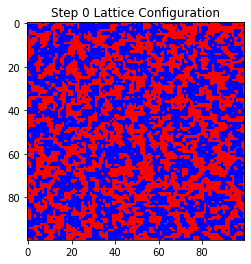

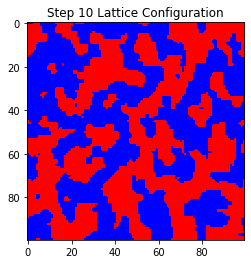

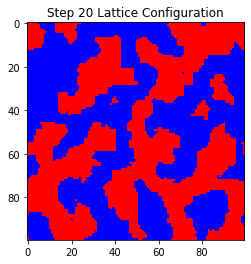

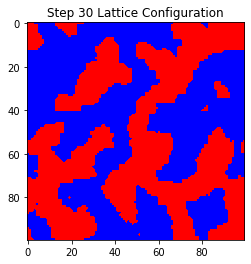

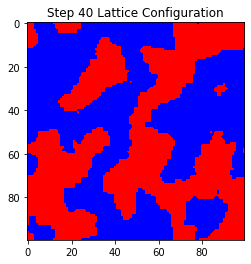

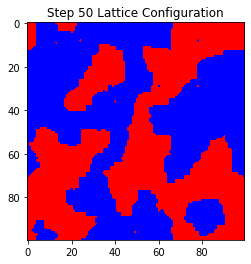

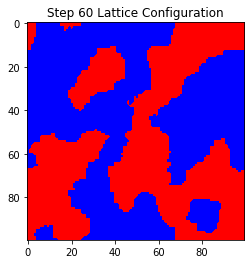

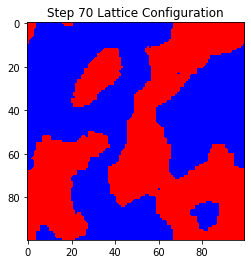

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f0aaedeb060>
Traceback (most recent call last):
  File "/home/paolo/.conda/envs/coderefinery/lib/python3.11/weakref.py", line 60, in _cb
    callback(self)
  File "/home/paolo/.conda/envs/coderefinery/lib/python3.11/site-packages/matplotlib/cbook/__init__.py", line 254, in _remove_proxy
    del self.callbacks[signal][cid]
        ~~~~~~~~~~~~~~^^^^^^^^
KeyError: 'changed'


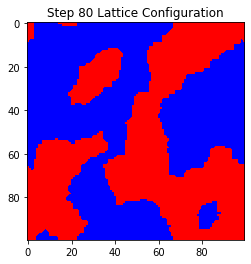

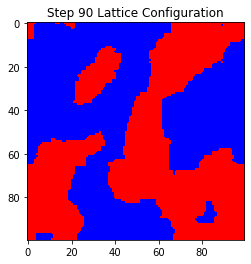

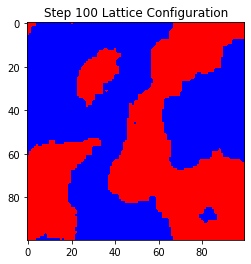

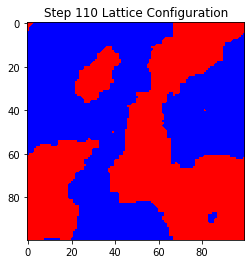

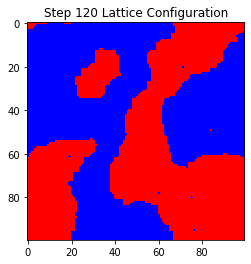

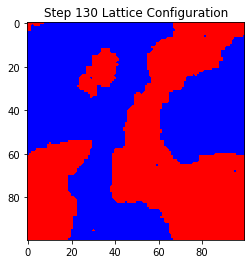

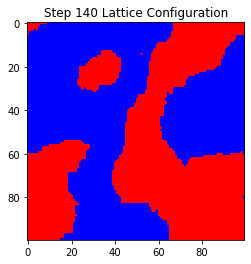

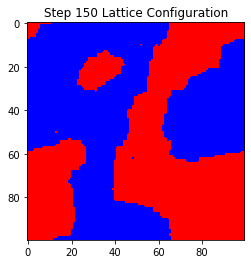

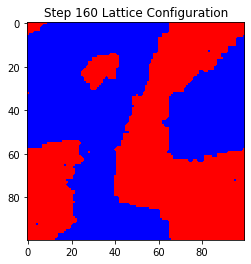

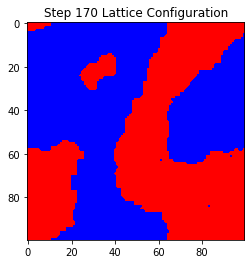

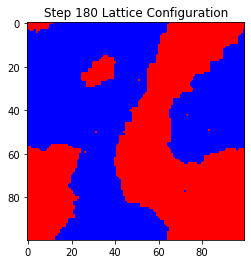

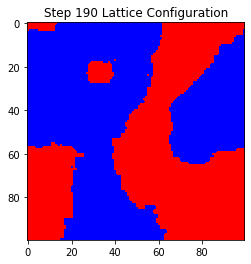

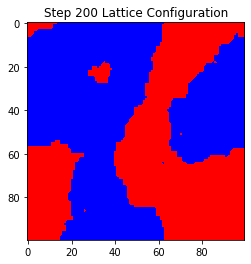

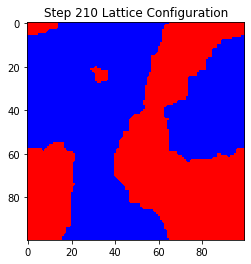

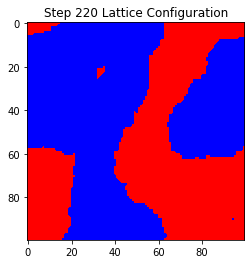

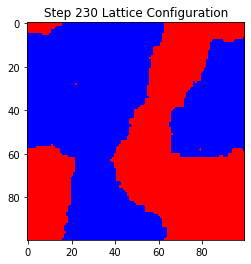

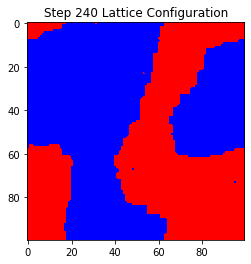

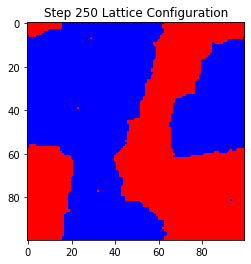

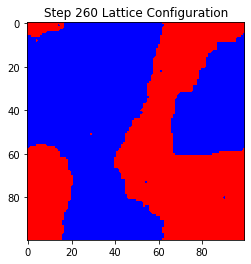

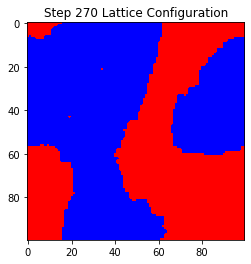

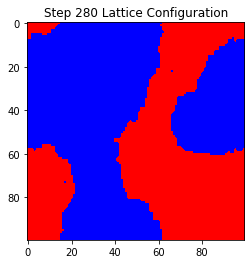

Equilibrium reached at step 290. Energy std: 0.0001


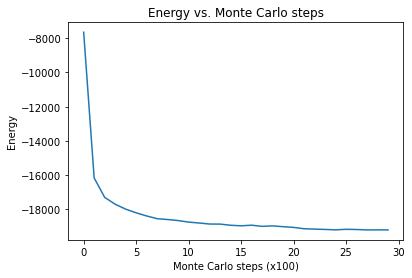

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import deque

def initialize_lattice(L, maj = 0):
    """Initialize a 2D lattice with spins randomly assigned to +1 or -1 or with a biased initialization."""
    lattice = np.zeros((L,L))
    if (maj == +1):
        init_random = np.random.random(size=(L, L))
        lattice[init_random>=0.25] = 1
        lattice[init_random<0.25] = -1
    elif (maj == -1):    
        init_random = np.random.random(size=(L, L))
        lattice[init_random>=0.75] = 1
        lattice[init_random<0.75] = -1
    else:
        lattice = np.random.choice([-1, 1], size=(L, L))
    return lattice

def compute_energy(lattice):
    """Compute the energy of the given lattice configuration."""
    L = lattice.shape[0]
    energy = 0
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
            # From the hamiltonian with h=0 and J=1 the energy E = - sum over nn( s_ij * s_nn)
            energy += -S * neighbors
    return energy / 2  # each pair counted twice

def monte_carlo_step(lattice, T):
    """Perform one Monte Carlo step."""
    L = lattice.shape[0]
    for _ in range(L**2):
        i, j = np.random.randint(0, L, size=2)
        S = lattice[i, j]
        neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
        # If a spin is flipped the energy difference is delta_E = s_ij * s_nn - (-s_ij * s_nn) = 2* s_ij* s_nn since the spin s_ij has been flipped s_ij --> -s_ij
        delta_E = 2 * S * neighbors
        # If the energy of the configuration has been lowered then the move is automatically accepted otherwise is accepted with an exponential probability
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
            lattice[i, j] *= -1
    return lattice

def monte_carlo_simulation(L, T, steps, strideval, cmap, norm, eq_window=30, eq_threshold=1e-4):
    """Run the Monte Carlo simulation."""
    # Inizialize the lattice
    lattice = initialize_lattice(L)
    energies = []
    # It can automatically discard the oldest values when it hits its max length.
    recent_energies = deque(maxlen=eq_window//strideval)
    #lattice = final_lattice
    for step in range(steps):
        # runs the montecarlo step
        lattice = monte_carlo_step(lattice, T)
        if step % strideval == 0:  # Record energy every strideval steps
            energy = compute_energy(lattice)
            energies.append(energy)
            recent_energies.append(energy)
            if len(recent_energies) == (eq_window//strideval):
                std_ratio = np.std(recent_energies)/abs(np.mean(recent_energies))
                # Confronts the std to mean ratio and stops the plotting once it goes below a certain threshold
                if std_ratio < eq_threshold:
                    print(f"Equilibrium reached at step {step}. Energy std: {std_ratio:.4f}")
                    break
            # Plot final lattice configuration
            plt.imshow(lattice, cmap=cmap, norm=norm)
            plt.title(f'Step {step} Lattice Configuration')
            plt.show()
    return lattice, energies

# Parameters
strideval = 10  # Stride value for printing
L = 100         # Lattice size (LxL)
#T = 3.0         # Temperature above the critical 
T = 1.0         # Temperature below the critical (Tc = 2.269 for J=1)
steps = 1500  # Number of Monte Carlo steps

# Create a colormap that distinguishes between -1 and +1
cmap = mcolors.ListedColormap(['blue', 'red'])

# Create a normalization that maps -1 to blue and +1 to white
norm = mcolors.BoundaryNorm([-1, 0, 1], cmap.N)

# Run simulation
final_lattice, energies = monte_carlo_simulation(L, T, steps, strideval, cmap, norm)

# Plot energy over time
plt.plot(energies)
plt.xlabel('Monte Carlo steps (x100)')
plt.ylabel('Energy')
plt.title('Energy vs. Monte Carlo steps')
plt.show()


In the Ising model, the parameter $J$ represents the interaction strength between neighboring spins. The choice of $J$ can significantly affect the behavior and properties of the system. Here are some considerations for choosing $J$:

1. **Normalization**: Often, $J$ is chosen to be 1 (i.e., $J = 1$). This is a convenient normalization that simplifies the model without loss of generality, as the relative strength of interactions and temperature are the key factors.

2. **Comparative Studies**: If you are comparing results with those of other studies, it is useful to use the same $J$ value as those studies to ensure consistency and comparability.

3. **Temperature Scaling**: The behavior of the Ising model depends on the ratio $\frac{J}{k_B T}$, where $k_B$ is the Boltzmann constant and $T$ is the temperature. In many computational studies, $k_B$ is set to 1, and $ T$ is varied. Thus, the choice of $J$ sets the energy scale, and the critical temperature $T_c$ for the 2D Ising model (without an external field) is known to be approximately $\frac{2J}{\ln(1 + \sqrt{2})} \approx 2.269$.

### Practical Considerations

For practical simulations and studies, the common practice is to set $J = 1$. This simplifies the interpretation and comparison of results. Here's how you can set $J$ and run the simulation:

1. **Setting $J = 1$**:
   ```python
   J = 1.0  # Interaction strength
   ```

2. **Temperature Range**: Explore temperatures around the critical temperature to study phase transitions and critical phenomena:
   ```python
   Tc = 2.269  # Approximate critical temperature for J=1
   ```

The behavior of the model depends on the ratio $\frac{J}{T}$, so setting $J = 1$ means temperature directly controls the system's behavior.

**Wolff Algorithm**: The Wolff algorithm is an efficient cluster algorithm for simulating the Ising model. Unlike the single-spin flip approach used in the Metropolis algorithm, the Wolff algorithm flips entire clusters of spins at once. This reduces critical slowing down near the critical temperature, where the system experiences long-range correlations.

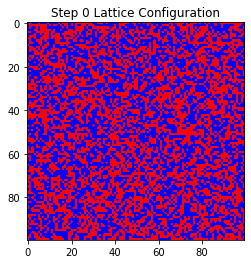

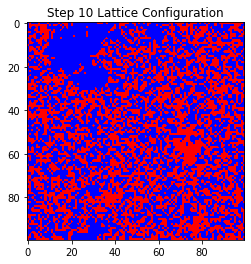

0.7257747386024233


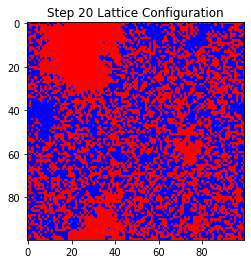

0.6225547397397726


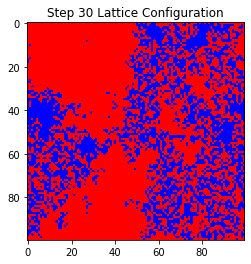

0.6998500109320015


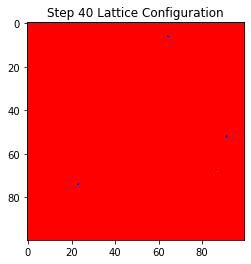

0.3679525694090887


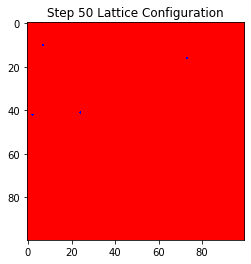

0.00018883877184845707
Equilibrium reached at step 60. Energy std: 0.0002


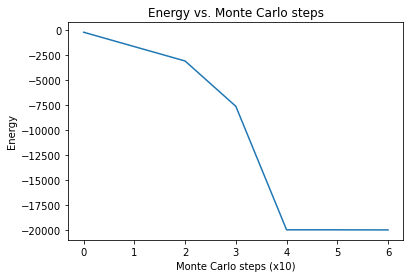

In [30]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def initialize_lattice(L, maj = 0):
    """Initialize a 2D lattice with spins randomly assigned to +1 or -1 or with a biased initialization."""
    lattice = np.zeros((L,L))
    if (maj == +1):
        init_random = np.random.random(size=(L, L))
        lattice[init_random>=0.25] = 1
        lattice[init_random<0.25] = -1
    elif (maj == -1):    
        init_random = np.random.random(size=(L, L))
        lattice[init_random>=0.75] = 1
        lattice[init_random<0.75] = -1
    else:
        lattice = np.random.choice([-1, 1], size=(L, L))
    return lattice

def wolff_step(lattice, T, J):
    """Perform one Wolff cluster update step."""
    L = lattice.shape[0]
    P_add = 1 - np.exp(-2 * J / T)  # Probability of adding a spin to the cluster

    # Randomly select a seed spin
    seed_i, seed_j = np.random.randint(0, L, size=2)
    seed_spin = lattice[seed_i, seed_j]

    # Initialize the cluster and the stack for checking neighbors
    cluster = set()
    cluster.add((seed_i, seed_j))
    stack = [(seed_i, seed_j)]

    while stack:
        i, j = stack.pop()

        # Check all four neighbors
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = (i + di) % L, (j + dj) % L
            if (ni, nj) not in cluster and lattice[ni, nj] == seed_spin:
                if np.random.rand() < P_add:
                    cluster.add((ni, nj))
                    stack.append((ni, nj))

    # Flip the entire cluster
    for i, j in cluster:
        lattice[i, j] *= -1

    return lattice


def monte_carlo_simulation(L, T, J, steps, strideval, cmap = cmap, norm = norm, eq_window=30, eq_threshold=1e-3):
    """Run the Monte Carlo simulation."""
    # Inizialize the lattice
    lattice = initialize_lattice(L)
    energies = []
    # It can automatically discard the oldest values when it hits its max length.
    recent_energies = deque(maxlen=eq_window//strideval)
    #lattice = final_lattice
    for step in range(steps):
        # runs the montecarlo step
        lattice = wolff_step(lattice, T, J)
        if step % strideval == 0:  # Record energy every strideval steps
            energy = compute_energy(lattice, J)
            energies.append(energy)
            recent_energies.append(energy)
            if len(recent_energies) == (eq_window//strideval):
                std_ratio = np.std(recent_energies)/abs(np.mean(recent_energies))
                print(std_ratio)
                # Confronts the std to mean ratio and stops the plotting once it goes below a certain threshold
                if std_ratio < eq_threshold:
                    print(f"Equilibrium reached at step {step}. Energy std: {std_ratio:.4f}")
                    break
            # Plot final lattice configuration
            plt.imshow(lattice, cmap=cmap, norm=norm)
            plt.title(f'Step {step} Lattice Configuration')
            plt.show()
    return lattice, energies


def compute_energy(lattice, J):
    """Compute the energy of the given lattice configuration."""
    L = lattice.shape[0]
    energy = 0
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L]
            energy += -J * S * neighbors
    return energy / 2  # each pair counted twice

# Parameters
strideval = 10  # Stride value for printing
L = 100        # Lattice size (LxL)
T = 1.0        # Temperature
J = 1.0        # Interaction strength
steps = 1500  # Number of Monte Carlo steps

# Create a colormap that distinguishes between -1 and +1
cmap = mcolors.ListedColormap(['blue', 'red'])

# Create a normalization that maps -1 to blue and +1 to white
norm = mcolors.BoundaryNorm([-1, 0, 1], cmap.N)

# Run simulation
final_lattice, energies = monte_carlo_simulation(L, T, J, steps, strideval, cmap, norm)

# Plot energy over time
plt.plot(energies)
plt.xlabel(f'Monte Carlo steps (x{strideval})')
plt.ylabel('Energy')
plt.title('Energy vs. Monte Carlo steps')
plt.show()
